In [1]:
#!pip install n2v
#!pip install albumentations

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import glob
import cv2
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
import albumentations as albu

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


2023-05-02 13:17:22.444445: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
datagen = N2V_DataGenerator()

In [2]:
INBREAST_PATH="/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/INBreast"
MIAS_PATH="/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/MIAS"
CBIS_DDSM_PATH="/kaggle/input/mias-cbis-ddsm-inbreast/Mammographies/CBIS-DDSM"

In [4]:
def get_images_paths(path):
    images_path=[]
    for (filepath, _, files) in os.walk(path, topdown=False):
        for file in files:
            if file.endswith(".png") and "MASK" not in file:
                images_path.append(os.path.join(filepath,file))
    return images_path
    

inbreast_files = get_images_paths(INBREAST_PATH)
cbis_ddsm_files = get_images_paths(MIAS_PATH)
mias_files = get_images_paths(CBIS_DDSM_PATH)

# To prevent unbalanced data from different datasets
samples_per_dataset=min(500, len(inbreast_files), len(cbis_ddsm_files), len(mias_files))

print(f"Samples per dataset = {samples_per_dataset}")

inbreast_files = np.random.choice(inbreast_files, size=samples_per_dataset, replace=False)
cbis_ddsm_files = np.random.choice(cbis_ddsm_files, size=samples_per_dataset, replace=False)
mias_files = np.random.choice(mias_files, size=samples_per_dataset, replace=False)

all_files = np.concatenate((inbreast_files, cbis_ddsm_files, mias_files), axis=None)

np.random.shuffle(all_files)

n_samples = len(all_files)
partitions = [int(0.75*n_samples), int(0.85*n_samples)]


train_list_files, val_list_files, test_list_files = np.split(all_files, partitions)

Samples per dataset = 322


In [5]:
train_list_files = tf.data.Dataset.from_tensor_slices(train_list_files)
val_list_files = tf.data.Dataset.from_tensor_slices(val_list_files)
test_list_files = tf.data.Dataset.from_tensor_slices(test_list_files)

2023-05-01 11:04:39.789079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 11:04:39.805540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-01 11:04:39.805754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
input_shape=(1600,1600)

In [86]:
def load_img_from_path(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, channels=1)
    img = tf.image.resize_with_pad(img,input_shape[0],input_shape[1])
    return img

def apply_clahe(image):
    image = image.astype("uint8")
    aug_img = albu.CLAHE(clip_limit=(1,10),p=1)(image = image)["image"]
    return aug_img.astype("uint8")

@tf.function
def preprocess_img(image):
    image = tf.numpy_function(apply_clahe, inp=[image], Tout=[tf.uint8])
    return image[0]
    

def load_and_process(path_list, batch_size=32):
    ds = path_list.map(load_img_from_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    # optimize performance
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    
    return ds

train_imgs = load_and_process(train_list_files, batch_size=1)
val_imgs = load_and_process(val_list_files, batch_size=1)
test_imgs = load_and_process(val_list_files, batch_size=1)

2023-05-01 12:31:02.127476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [724]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:31:02.127785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [724]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:31:12.181507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 701 of 1000
2023-05-01 12:31:12.460526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


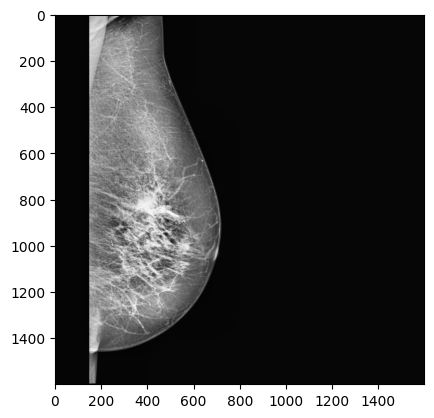

2023-05-01 12:31:12.753844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:31:12.754127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


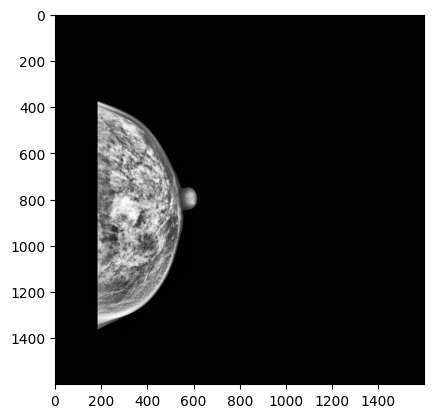

In [87]:
plt.imshow((next(iter(train_imgs.take(1))))[0], cmap="gray")
plt.show()
plt.imshow((next(iter(val_imgs.take(1))))[0], cmap="gray")
plt.show()

In [8]:
# We will use the first image to extract training patches and store them in 'X'
patch_shape = (64,64)

X = datagen.generate_patches_from_list(train_imgs, shape=patch_shape, num_patches_per_img=12)

# We will use the second image to extract validation patches.
X_val = datagen.generate_patches_from_list(val_imgs, shape=patch_shape, num_patches_per_img=12)

2023-05-01 11:04:53.531183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [724]
	 [[{{node Placeholder/_0}}]]
2023-05-01 11:04:53.531484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [724]
	 [[{{node Placeholder/_0}}]]
2023-05-01 11:05:03.564304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 694 of 1000
2023-05-01 11:05:03.930503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (

Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (

Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (

2023-05-01 11:05:07.738851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 11:05:07.739069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (96, 64, 64, 1)
Generated patches: (

In [9]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/32), train_epochs=50, train_loss='mse', batch_norm=True, 
                   train_batch_size=16, n2v_perc_pix=0.198, n2v_patch_shape=patch_shape, 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

In [10]:
# a name used to identify the model
model_name = 'n2v_2D'
# the base directory in which our model will live
basedir = '/kaggle/working/models'

os.makedirs(basedir, exist_ok=True)
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

/usr/local/lib/python3.8/dist-packages/n2v/models/n2v_standard.py:429: UserWarning: output path for model already exists, files may be overwritten: /kaggle/working/models/n2v_2D
  warnings.warn(


In [11]:
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 9312/9312 [00:02<00:00, 4116.69it/s]

Epoch 1/50



2023-05-01 11:05:14.808980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-01 11:05:17.836179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-01 11:05:19.590305: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7faaa047c480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-01 11:05:19.590348: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-05-01 11:05:19.654499: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-01 11:05:19

2172/2172 [==============================] - 47s 17ms/step - loss: 0.0535 - n2v_mse: 0.0535 - n2v_abs: 0.1275 - val_loss: 0.0128 - val_n2v_mse: 0.0128 - val_n2v_abs: 0.0600 - lr: 4.0000e-04
Epoch 2/50
2172/2172 [==============================] - 37s 17ms/step - loss: 0.0232 - n2v_mse: 0.0232 - n2v_abs: 0.0832 - val_loss: 0.0323 - val_n2v_mse: 0.0323 - val_n2v_abs: 0.1559 - lr: 4.0000e-04
Epoch 3/50
2172/2172 [==============================] - 38s 18ms/step - loss: 0.0153 - n2v_mse: 0.0153 - n2v_abs: 0.0656 - val_loss: 0.0053 - val_n2v_mse: 0.0053 - val_n2v_abs: 0.0369 - lr: 4.0000e-04
Epoch 4/50
2172/2172 [==============================] - 39s 18ms/step - loss: 0.0114 - n2v_mse: 0.0114 - n2v_abs: 0.0569 - val_loss: 0.0061 - val_n2v_mse: 0.0061 - val_n2v_abs: 0.0437 - lr: 4.0000e-04
Epoch 5/50
2172/2172 [==============================] - 39s 18ms/step - loss: 0.0098 - n2v_mse: 0.0098 - n2v_abs: 0.0524 - val_loss: 0.0057 - val_n2v_mse: 0.0057 - val_n2v_abs: 0.0368 - lr: 4.0000e-04
Epoch 

Epoch 27/50
2172/2172 [==============================] - 40s 19ms/step - loss: 0.0047 - n2v_mse: 0.0047 - n2v_abs: 0.0323 - val_loss: 0.0051 - val_n2v_mse: 0.0051 - val_n2v_abs: 0.0357 - lr: 2.0000e-04
Epoch 28/50
2172/2172 [==============================] - 40s 19ms/step - loss: 0.0046 - n2v_mse: 0.0046 - n2v_abs: 0.0318 - val_loss: 0.0061 - val_n2v_mse: 0.0061 - val_n2v_abs: 0.0378 - lr: 2.0000e-04
Epoch 29/50
2172/2172 [==============================] - 40s 18ms/step - loss: 0.0046 - n2v_mse: 0.0046 - n2v_abs: 0.0317 - val_loss: 0.0050 - val_n2v_mse: 0.0050 - val_n2v_abs: 0.0313 - lr: 2.0000e-04
Epoch 30/50
2172/2172 [==============================] - 40s 19ms/step - loss: 0.0047 - n2v_mse: 0.0047 - n2v_abs: 0.0320 - val_loss: 0.0058 - val_n2v_mse: 0.0058 - val_n2v_abs: 0.0363 - lr: 2.0000e-04
Epoch 31/50
2172/2172 [==============================] - 40s 18ms/step - loss: 0.0046 - n2v_mse: 0.0046 - n2v_abs: 0.0314 - val_loss: 0.0052 - val_n2v_mse: 0.0052 - val_n2v_abs: 0.0345 - lr: 2

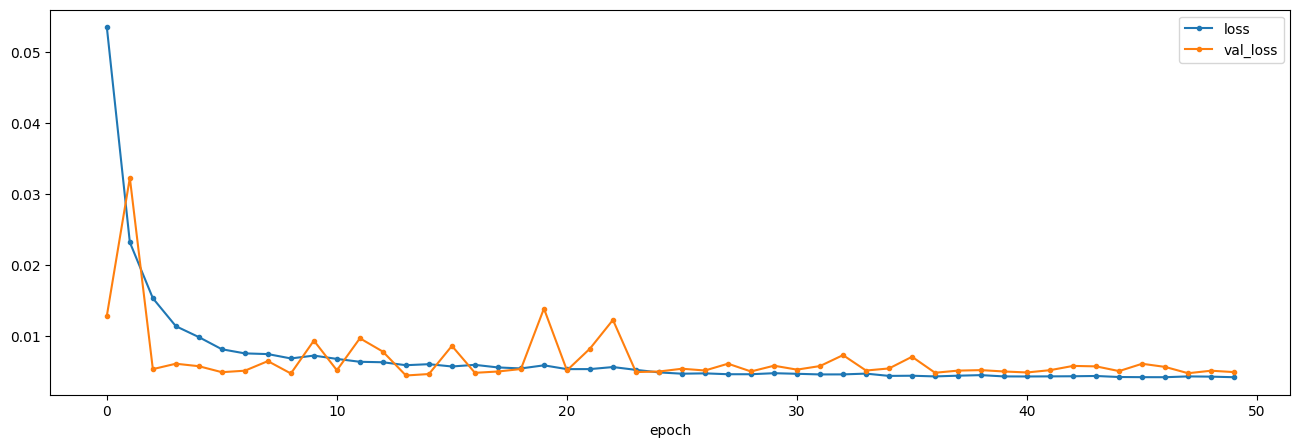

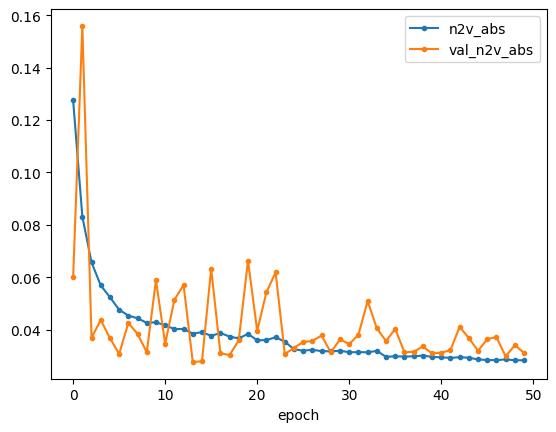

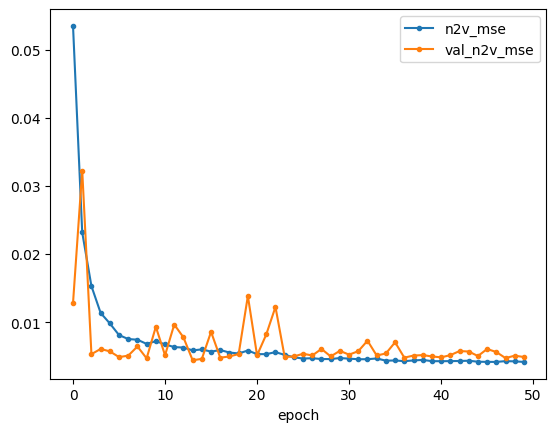

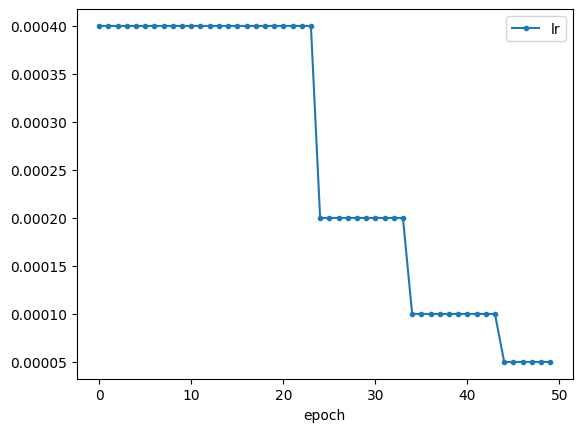

In [15]:
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);
plot_history(history,['n2v_abs','val_n2v_abs']);
plot_history(history,['n2v_mse','val_n2v_mse']);
plot_history(history,['lr']);

2023-05-01 12:15:06.938852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:06.939358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


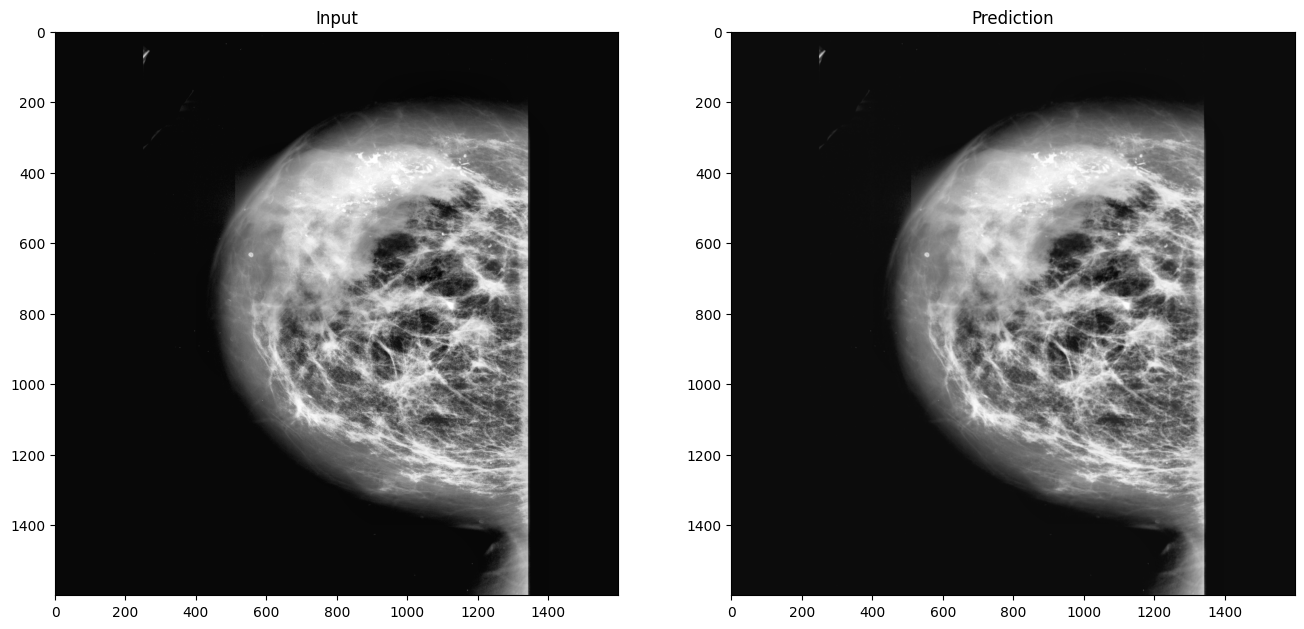

2023-05-01 12:15:09.216381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:09.216643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


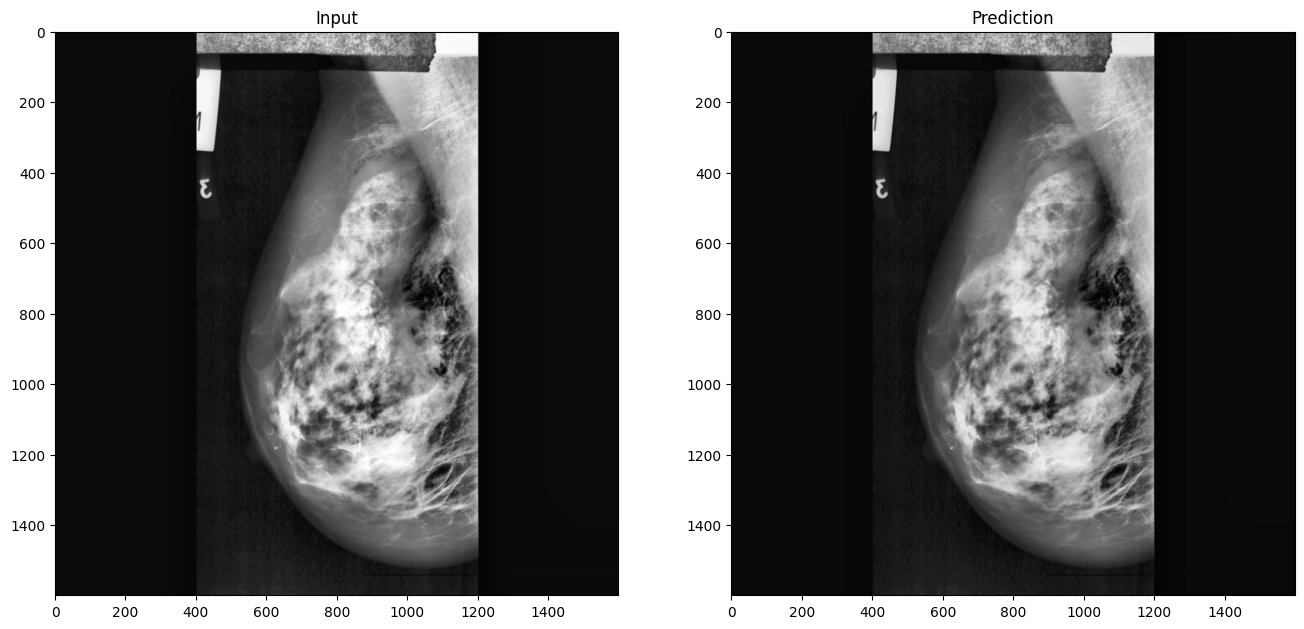

2023-05-01 12:15:11.510513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:11.510759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


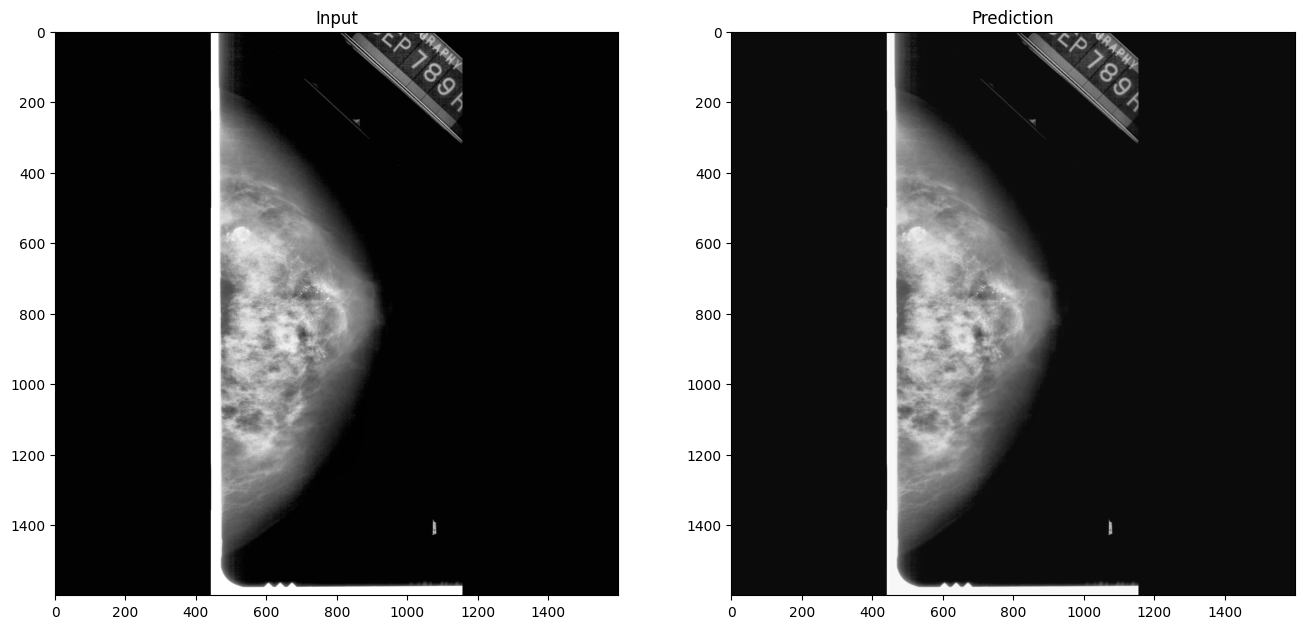

2023-05-01 12:15:13.789941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:13.790369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 17ms/step


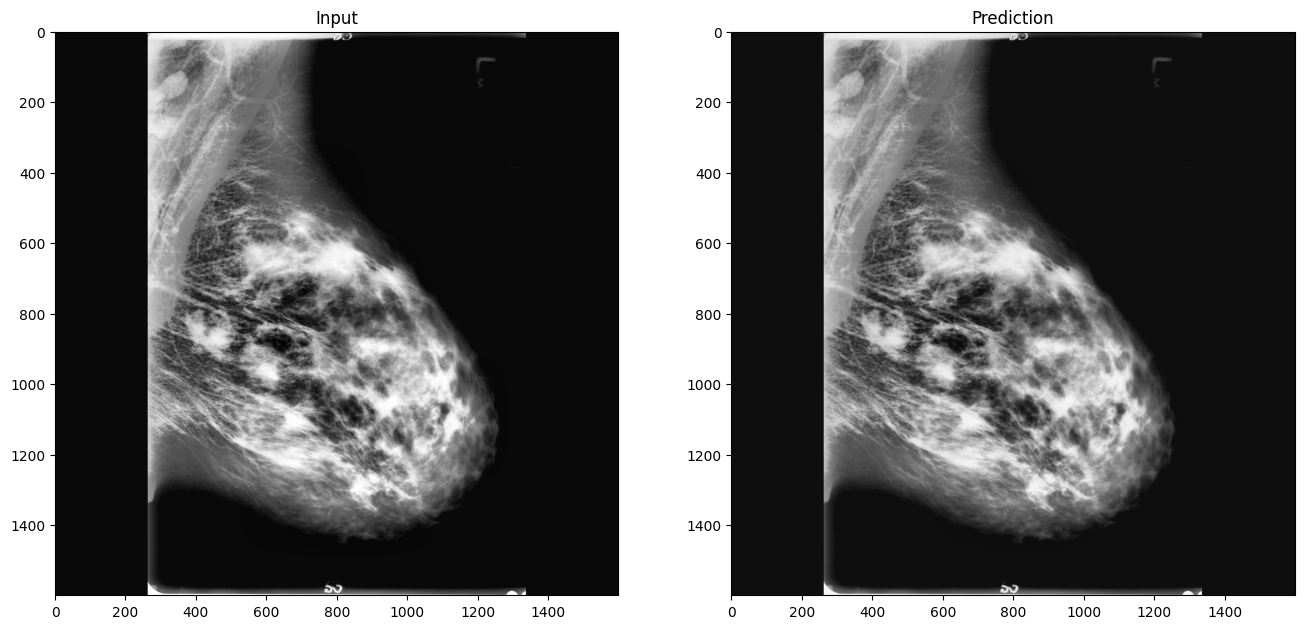

2023-05-01 12:15:16.045258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:16.045558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 19ms/step


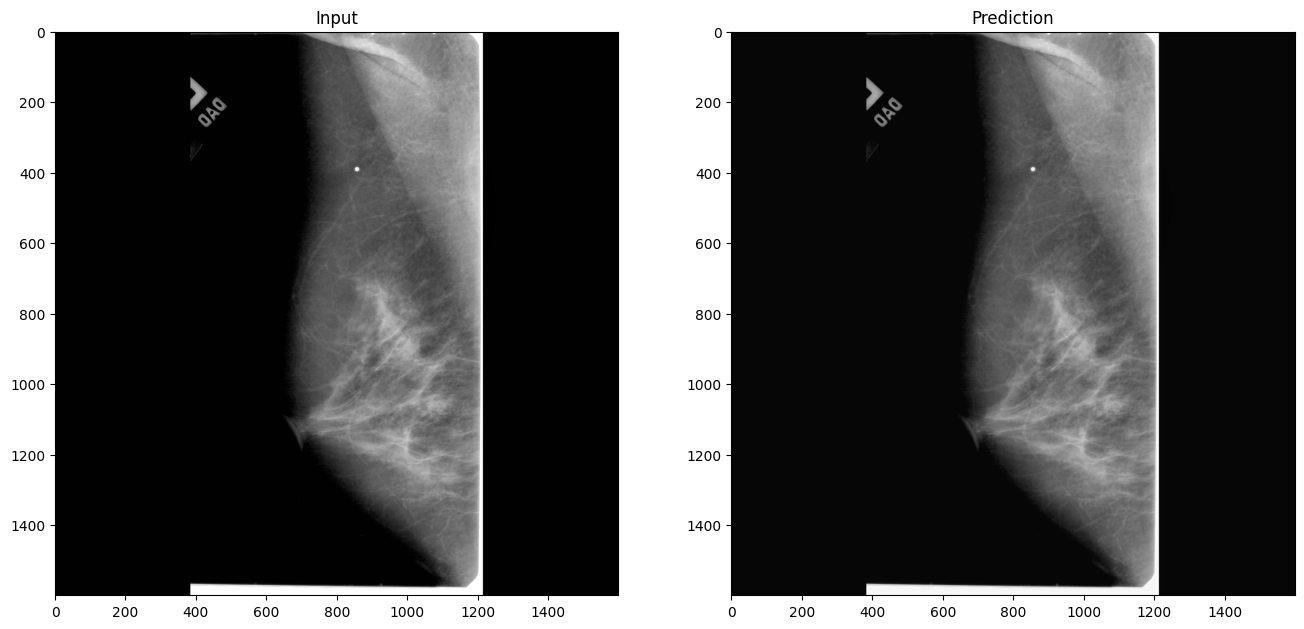

2023-05-01 12:15:18.302207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:18.302469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


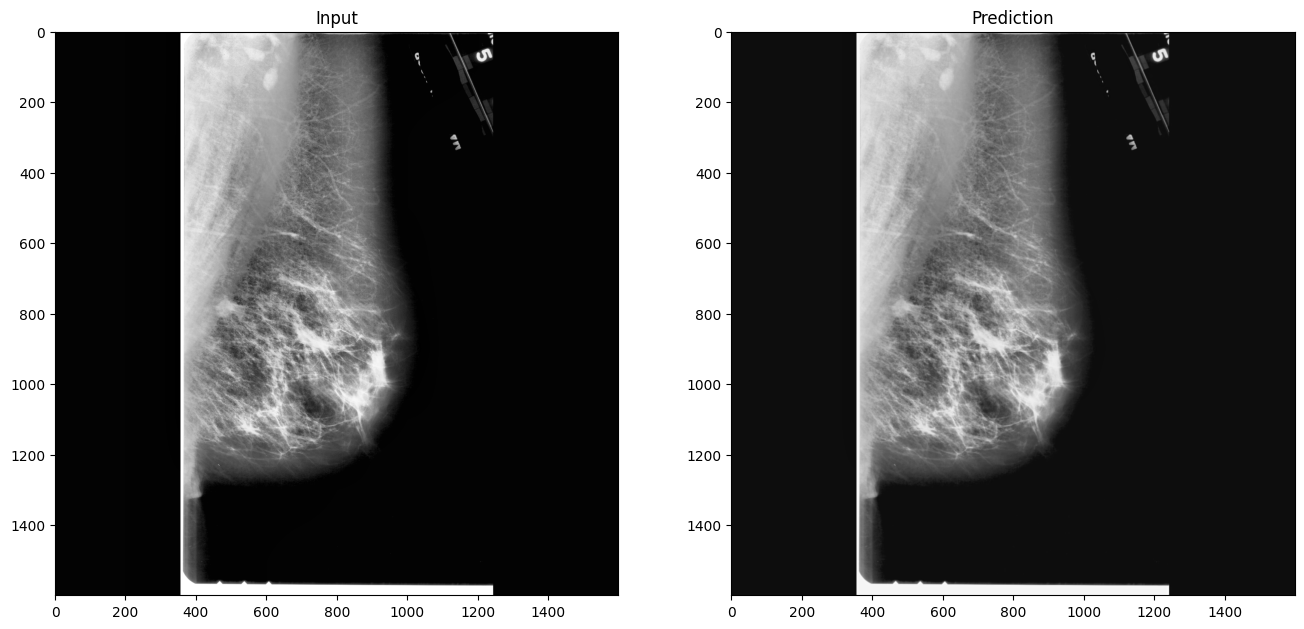

2023-05-01 12:15:20.557725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:20.557990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


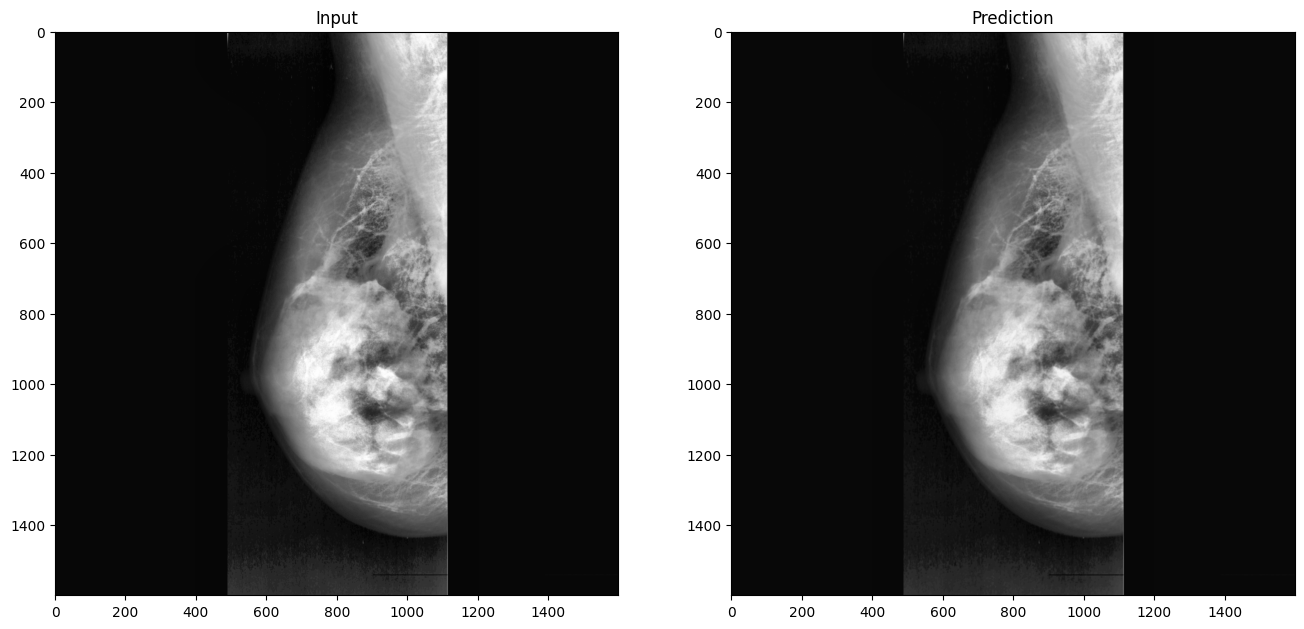

2023-05-01 12:15:23.034905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:23.035173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 22ms/step


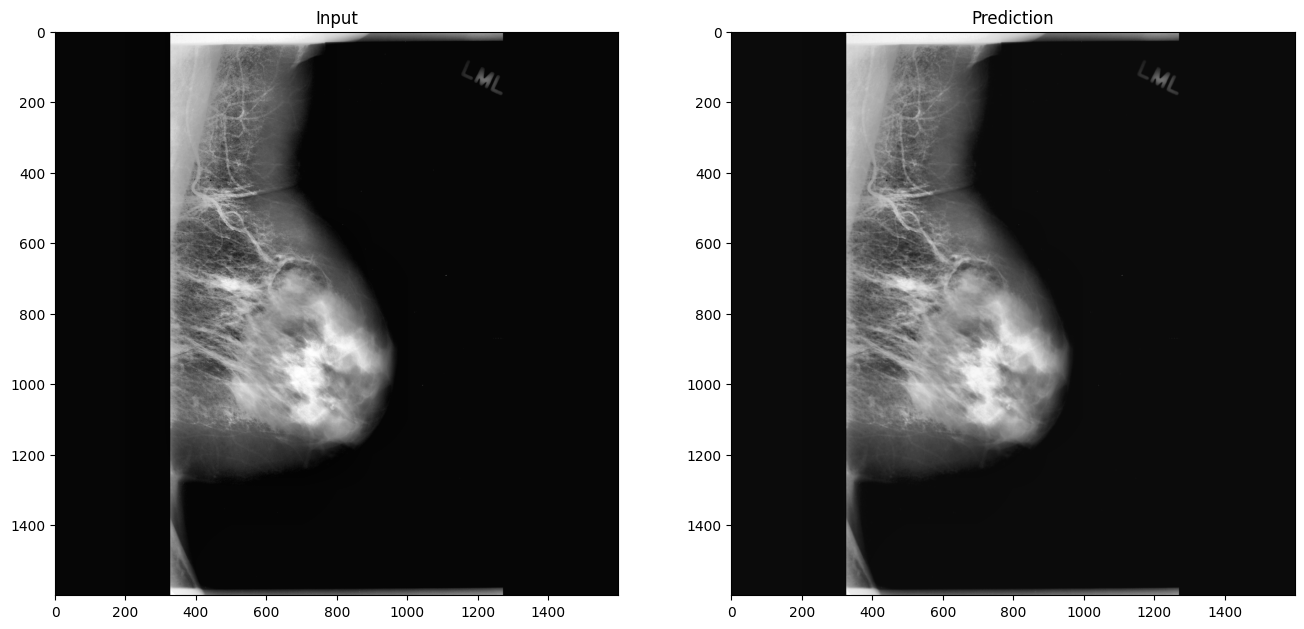

2023-05-01 12:15:25.389463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:25.389753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 24ms/step


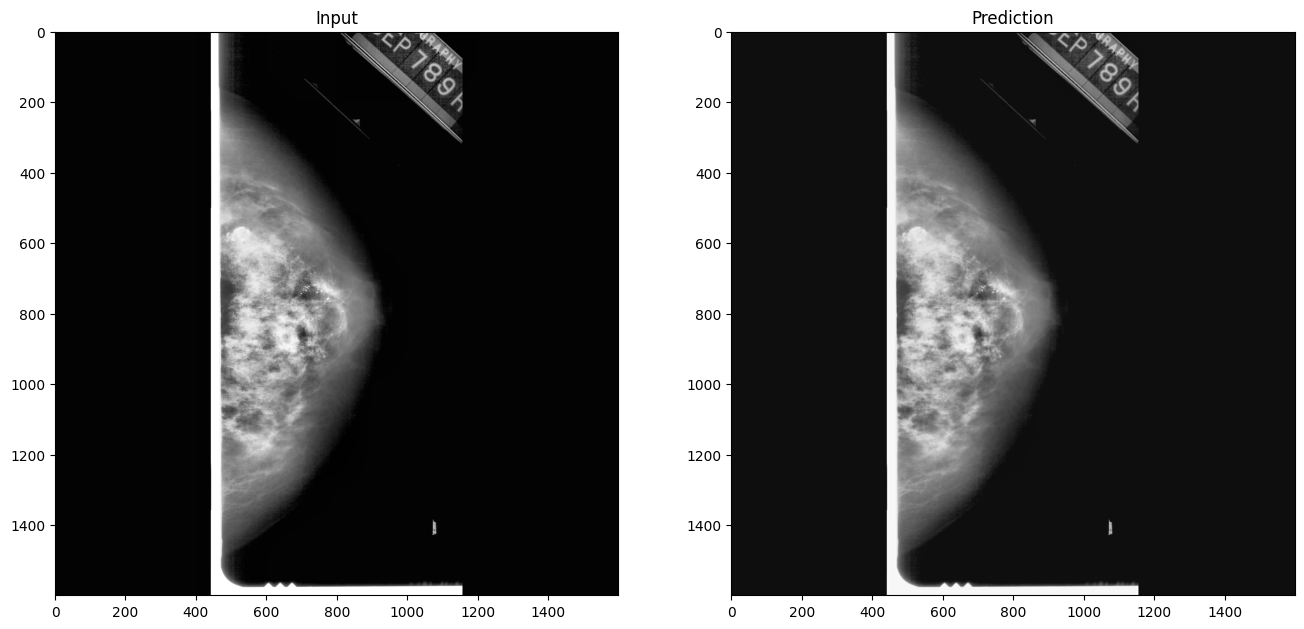

2023-05-01 12:15:27.760926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]
2023-05-01 12:15:27.761180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [97]
	 [[{{node Placeholder/_0}}]]


The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 0s 18ms/step


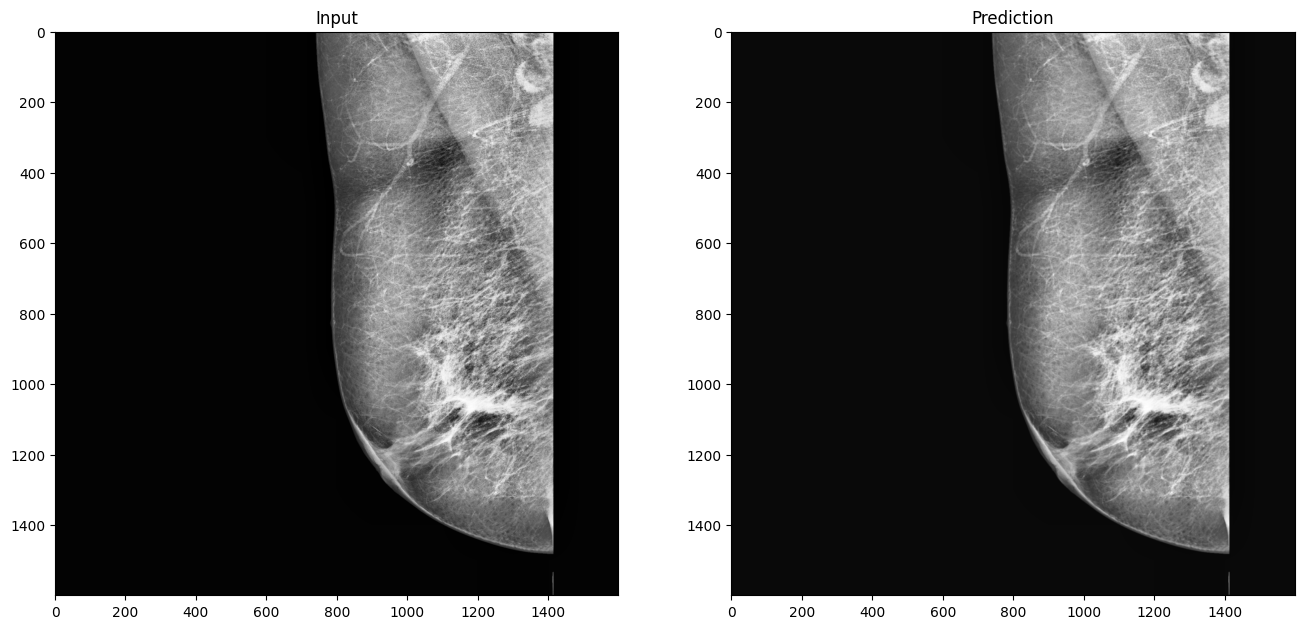

In [63]:
# We can optionally apply an 8bits coding for color
def to_8_bits_color(img_array):
    norm_img_array = img_array / \
        img_array.max() * 255
    return norm_img_array

for i in range(10):
    input_val=np.array(next(iter(test_imgs.take(1)))[0]).reshape(input_shape)
    pred_val=model.predict(input_val, axes="YX")

    # Let's look at the results.
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(input_val,cmap="gray")
    plt.title('Input');
    plt.subplot(1,2,2)
    plt.imshow(pred_val,cmap="gray")
    plt.title('Prediction');
    plt.show()
    cv2.imwrite(f"/kaggle/working/input_n2v_{i+1}.png", input_val)
    cv2.imwrite(f"/kaggle/working/predict_n2v_{i+1}.png", pred_val)